In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykrx import stock
import datetime
import time

# 주어진 주식 코드와 날짜 범위에 대한 시장 데이터를 가져오는 함수
def get_market_data(start_date, end_date, stock_code):
    df = stock.get_market_ohlcv(start_date, end_date, stock_code)
    return df






# 종목 수익률 상관관계

In [33]:
# 기존 주식 코드 목록
existing_stock_codes = [
    '010420', '016920', '021240', '032750', '037400', '039740',
    '045060', '075130', '088790', '225590', '334690', '364990',
    '010470', '084010', '093920', '371460', '317400', '228800',
    '139250', '271060', '304660', '244580', '037710', '136540'
] # 24 종목


# 각 주식에 대한 데이터를 저장할 딕셔너리
stock_data = {}

# 각 주식에 대한 시장 데이터를 가져와 딕셔너리에 저장
for code in stock_codes:
    df = get_market_data("20160102", "20231220", code)
    df.index = pd.to_datetime(df.index)
    stock_data[code] = df

# # 데이터 확인
# for code, df in stock_data.items():
#     print(f"{code} 데이터 샘플:")
#     print(df.head())

In [34]:
# 수익률과 상관관계를 계산
returns = pd.DataFrame(index=stock_data[stock_codes[0]].index)
for code in stock_codes:
    df = stock_data[code]
    for period, label in zip([1, 5, 20, 252], ['daily', 'weekly', 'monthly', 'yearly']):
        returns[f'{code}_{label}_return'] = df['종가'].pct_change(periods=period)

# pct_change 계산으로 인해 발생한 NaN 값을 제거
returns.dropna(inplace=True)




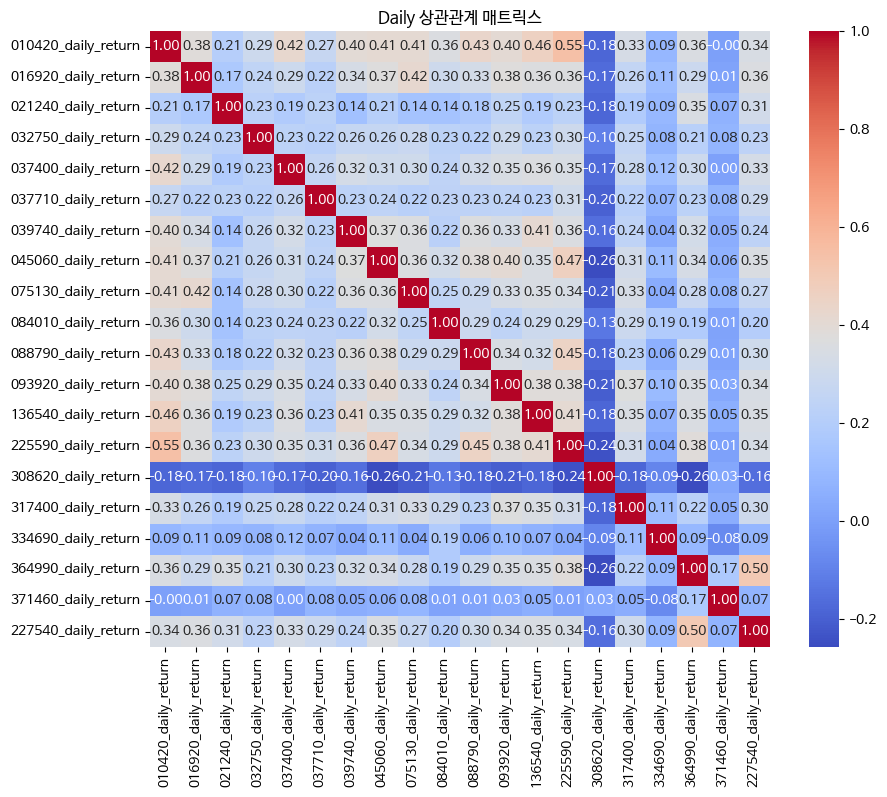

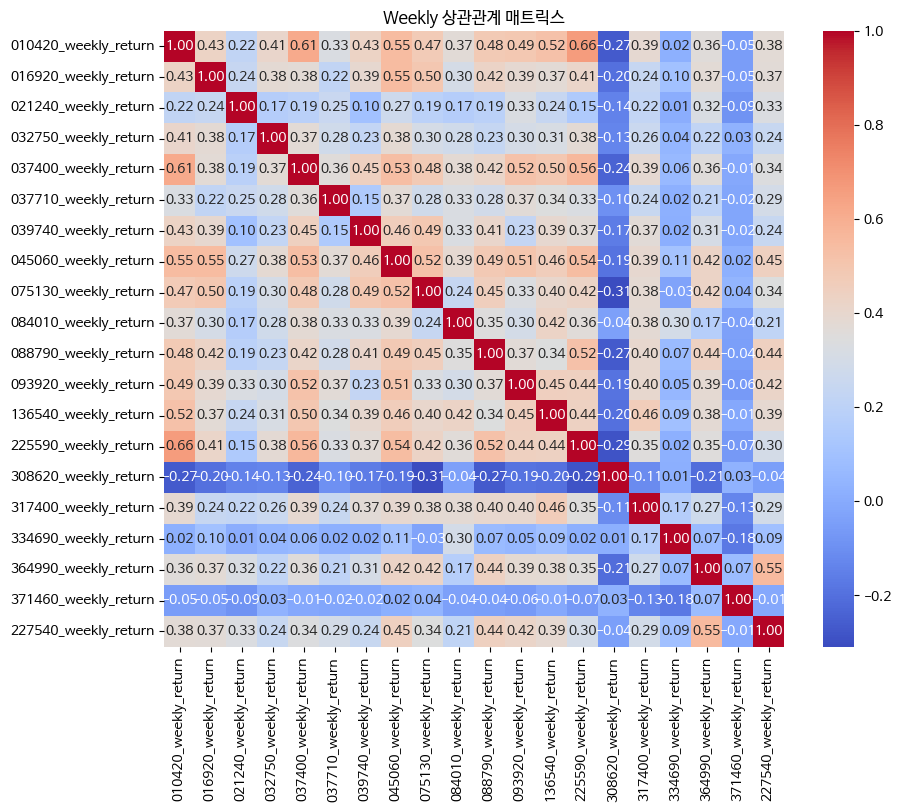

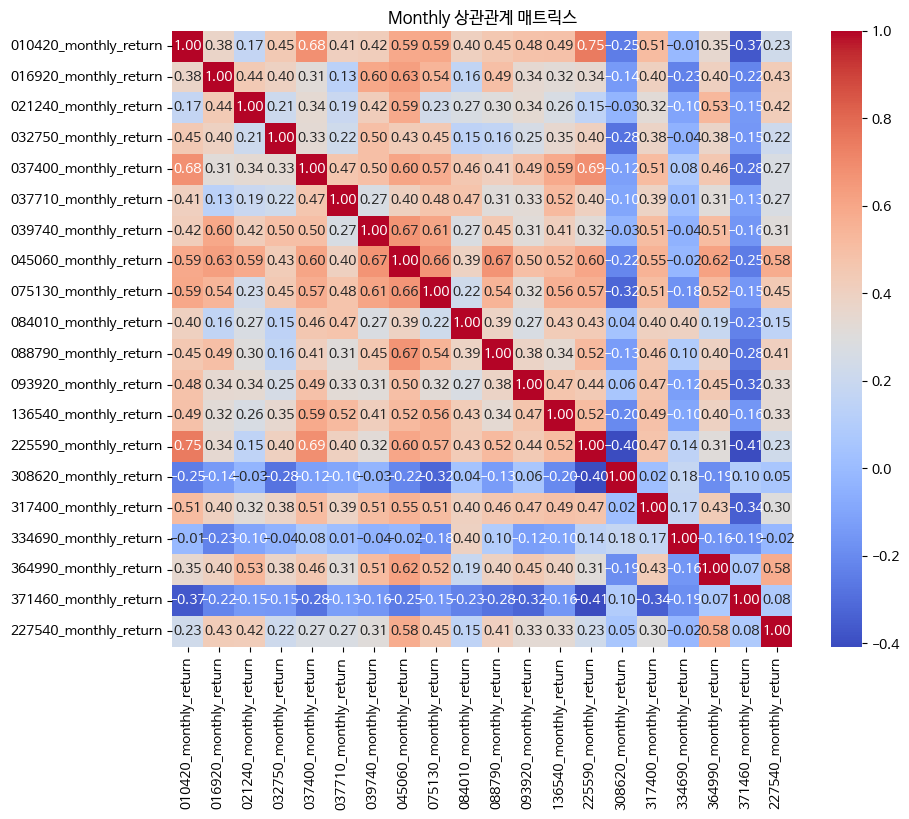

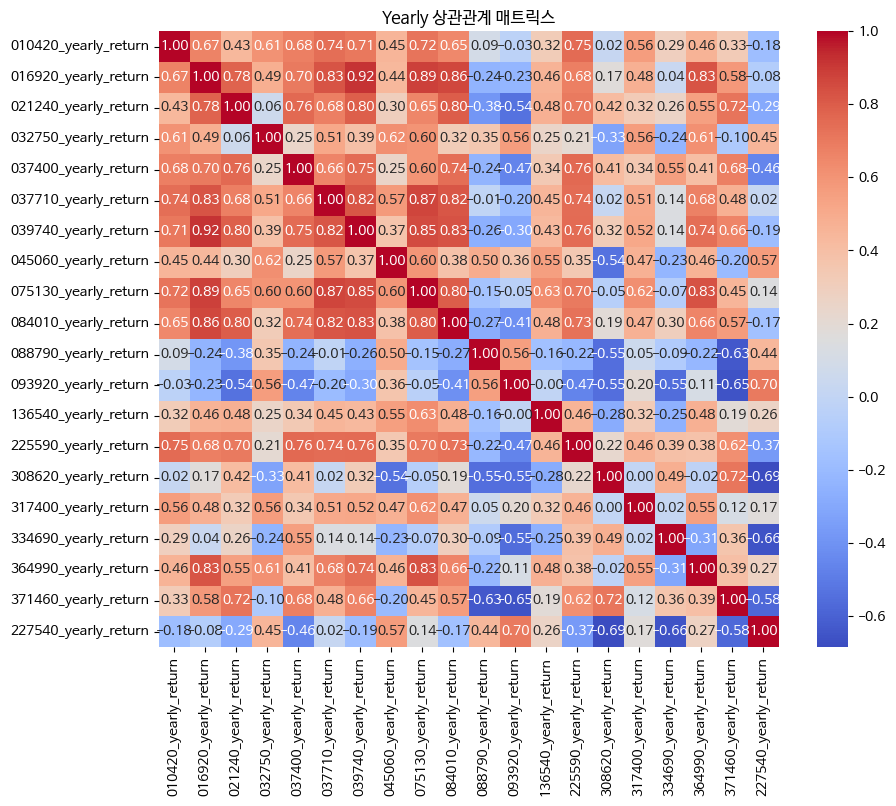

상관관계 매트릭스 내용 확인


In [35]:


# 다양한 기간에 대한 상관관계 매트릭스를 계산
timeframes = ['daily', 'weekly', 'monthly', 'yearly']
correlation_matrices = {timeframe: returns.filter(regex=f'_{timeframe}_').corr() for timeframe in ['daily', 'weekly', 'monthly', 'yearly']}


# 상관관계 매트릭스를 시각화
for timeframe, matrix in correlation_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'{timeframe.capitalize()} 상관관계 매트릭스')
    plt.show()


# 상관관계 매트릭스 내용 확인
print("상관관계 매트릭스 내용 확인")
timeframes = ['daily', 'weekly', 'monthly', 'yearly']
correlation_matrices = {timeframe: returns.filter(regex=f'_{timeframe}_return').corr() for timeframe in timeframes}

In [36]:
# 각 주식이 다른 모든 주식과의 평균 상관관계를 계산
stock_average_correlations = {timeframe: {} for timeframe in timeframes}

for timeframe, matrix in correlation_matrices.items():
    # 열 이름에서 주식 코드를 추출
    stock_codes_in_matrix = matrix.columns.str.extract(r'(\d+)')[0]
    matrix.columns = stock_codes_in_matrix  # 열 이름을 주식 코드로 변경
    matrix.index = stock_codes_in_matrix  # 인덱스를 주식 코드로 변경
    for stock_code in stock_codes:
        if stock_code in matrix.columns:
            # 해당 주식이 다른 모든 주식과의 상관관계
            stock_correlations = matrix[stock_code]
            # 자신의 상관관계를 제외한 평균 상관관계 계산
            stock_average_correlations[timeframe][stock_code] = stock_correlations.drop(labels=[stock_code]).mean()

# 평균 상관관계 테이블 생성 및 출력
average_correlations_table = pd.DataFrame(stock_average_correlations).T
average_correlations_table = average_correlations_table.round(3)

print("평균 상관관계 테이블:")
print(average_correlations_table)

# 테이블을 CSV 파일로 저장 (선택 사항)
# average_correlations_table.to_csv('average_correlations.csv')

평균 상관관계 테이블:
         010420  016920  021240  032750  037400  037710  039740  045060  \
daily     0.312   0.265   0.175   0.213   0.252   0.202   0.254   0.283   
weekly    0.358   0.306   0.177   0.246   0.349   0.239   0.272   0.380   
monthly   0.354   0.302   0.259   0.253   0.387   0.282   0.361   0.448   
yearly    0.435   0.488   0.394   0.326   0.406   0.491   0.486   0.330   

         075130  084010  088790  093920  136540  225590  308620  317400  \
daily     0.255   0.218   0.256   0.280   0.281   0.297  -0.170   0.235   
weekly    0.313   0.273   0.315   0.317   0.332   0.329  -0.161   0.282   
monthly   0.378   0.277   0.335   0.304   0.344   0.340  -0.104   0.365   
yearly    0.507   0.460  -0.076  -0.103   0.284   0.414  -0.002   0.356   

         334690  364990  371460  227540  
daily     0.071   0.261   0.042   0.267  
weekly    0.054   0.287  -0.031   0.296  
monthly  -0.007   0.345  -0.186   0.296  
yearly    0.031   0.413   0.247  -0.033  


# 종목의 표준편차 계산

In [38]:
# 문자열을 실수로 변환하는 함수
import math
def convert_to_float(x):
    try:
        return float(x.replace(',', ''))  # 콤마 제거 후 실수로 변환
    except:
        return x

# '종가', '시가' 열의 값들을 실수로 변환합니다.
df['종가'] = df['종가'].apply(convert_to_float)
df['시가'] = df['시가'].apply(convert_to_float)

# 일별 수익률을 계산합니다. (당일 종가 / 당일 시가 - 1)
df['수익률'] = df['종가'] / df['시가'] - 1

# 수익률의 표준편차를 계산합니다.
std_dev = df['수익률'].std()

# 연간 표준편차 계산
annual_std_dev = std_dev * math.sqrt(12)


print(std_dev)

print(annual_std_dev)

0.01633126831188192
0.05657317293643818


In [40]:
# 연환산 수익률을 계산하는 함수
def calculate_annualized_return(df):
    initial_price = df.iloc[-1]['종가']
    current_price = df.iloc[0]['종가']
    start_date = pd.to_datetime(df.index[-1])
    end_date = pd.to_datetime(df.index[0])
    duration_years = (end_date - start_date).days / 365.25
    total_return = (current_price / initial_price) - 1
    annualized_return = ((1 + total_return)**(1/duration_years)) - 1
    return annualized_return


# 예시: 단일 주식 데이터에 대해 연환산 수익률 계산
if 'df' in locals():
    annualized_return = calculate_annualized_return(df)
    print(f"2001년 01월부터 현재까지의 연환산 수익률: {annualized_return * 100:.2f}%")







2001년 01월부터 현재까지의 연환산 수익률: -2.77%


In [41]:
# 모든 주식 티커를 수집하는 함수
def collect_all_tickers(start_year=1990):
    current_year = datetime.datetime.now().year
    all_tickers = set()
    for year in range(start_year, current_year + 1):
        date_str = f"{year}1231"
        tickers_kosdaq = stock.get_market_ticker_list(date_str, market='KOSDAQ')
        tickers_kospi = stock.get_market_ticker_list(date_str, market='KOSPI')
        all_tickers.update(tickers_kosdaq)
        all_tickers.update(tickers_kospi)
        time.sleep(1)
    return all_tickers

# 티커 수집
all_tickers = collect_all_tickers()
print(f"수집된 총 티커 수: {len(all_tickers)}")

수집된 총 티커 수: 4900


In [23]:
a=stock.get_market_ticker_name('304660')
print(a)


Empty DataFrame
Columns: []
Index: []


새로운 종목 동화약품(000020)의 기존 포트폴리오와의 상관관계 점수:
Daily 상관관계 점수: 0.560
Weekly 상관관계 점수: 0.587
Monthly 상관관계 점수: 0.571
Yearly 상관관계 점수: 0.474
새로운 종목 동화약품(000020)의 Normalized ATR:
              종가         ATR  Normalized ATR (%)
날짜                                              
2023-01-02  9500         NaN                 NaN
2023-01-03  9200         NaN                 NaN
2023-01-04  9330         NaN                 NaN
2023-01-05  9350         NaN                 NaN
2023-01-06  9410         NaN                 NaN
...          ...         ...                 ...
2024-09-02  8000  171.428571            2.142857
2024-09-03  8020  160.000000            1.995012
2024-09-04  7820  172.142857            2.201315
2024-09-05  7800  178.571429            2.289377
2024-09-06  7640  174.285714            2.281227

[415 rows x 3 columns]


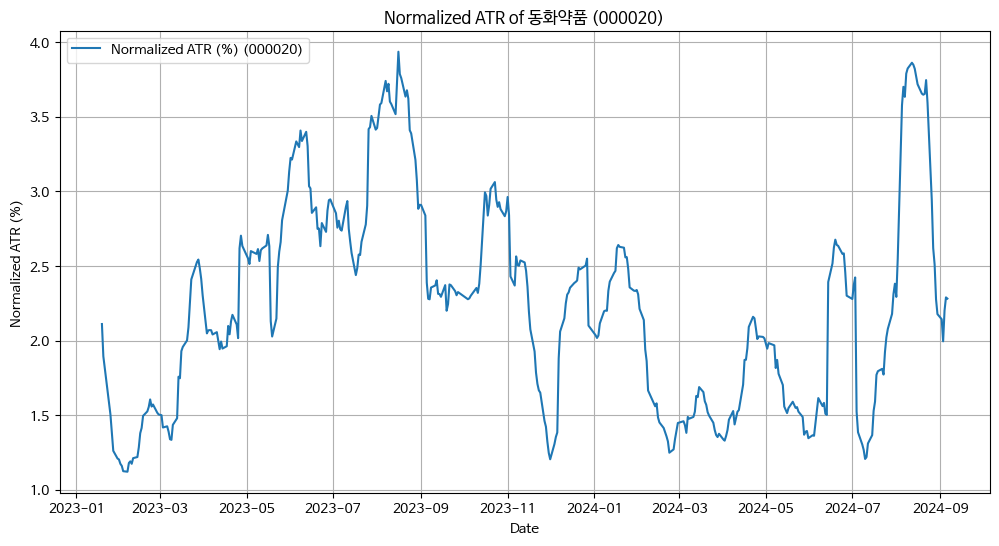

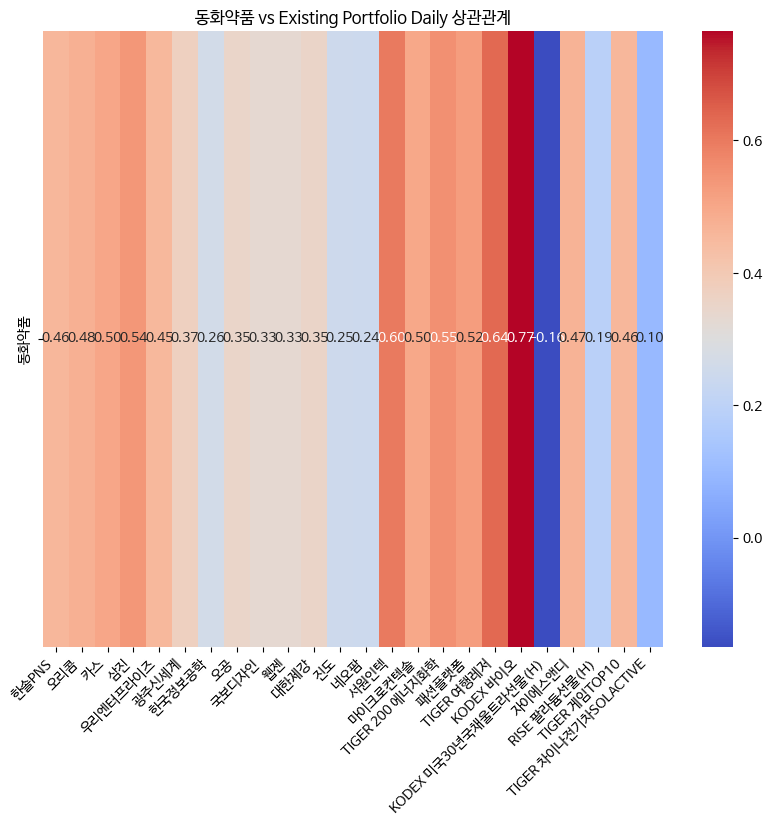

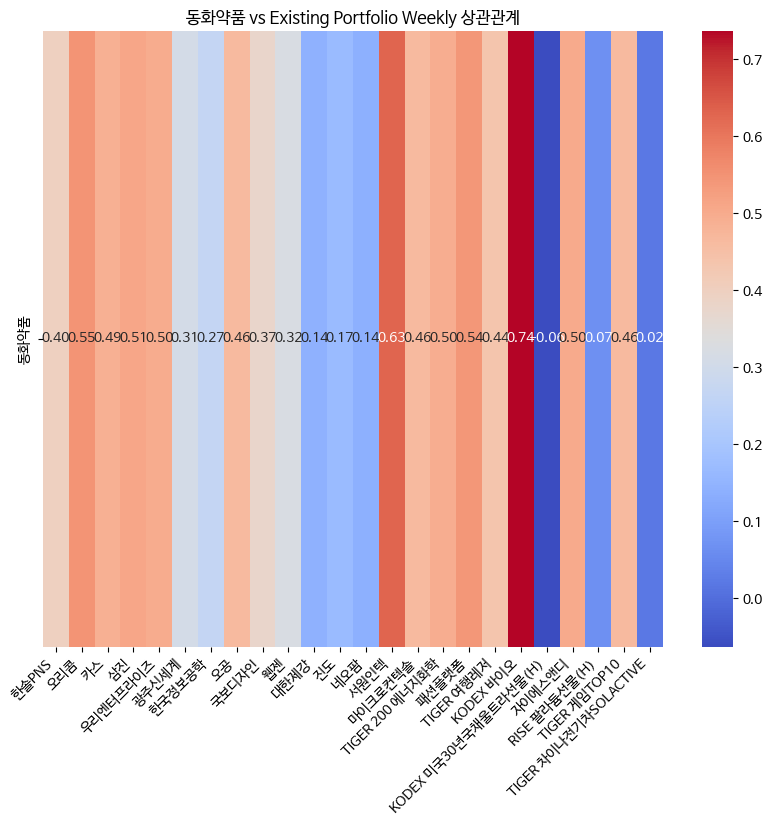

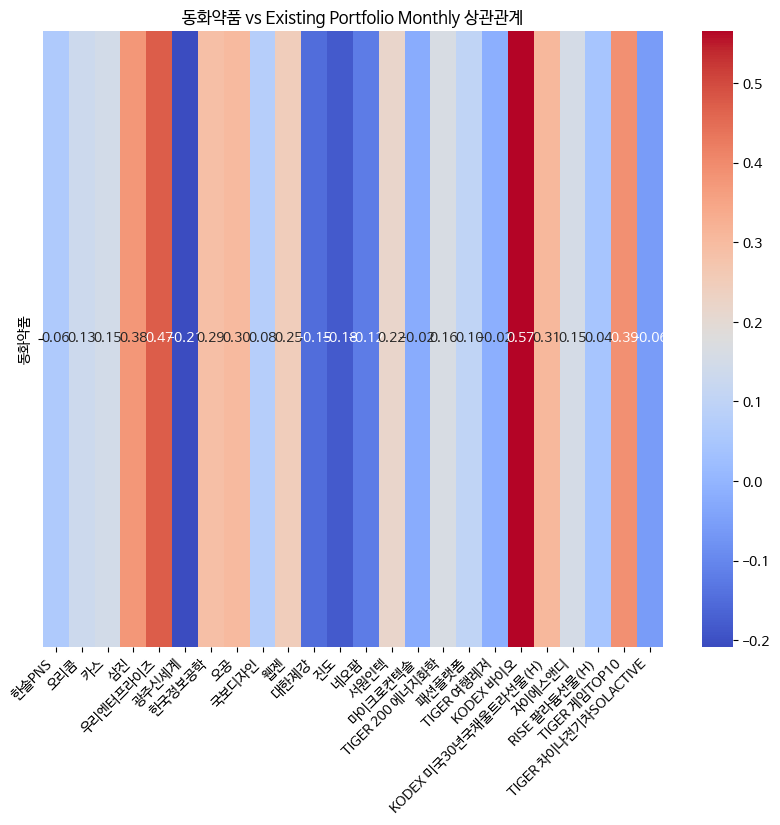

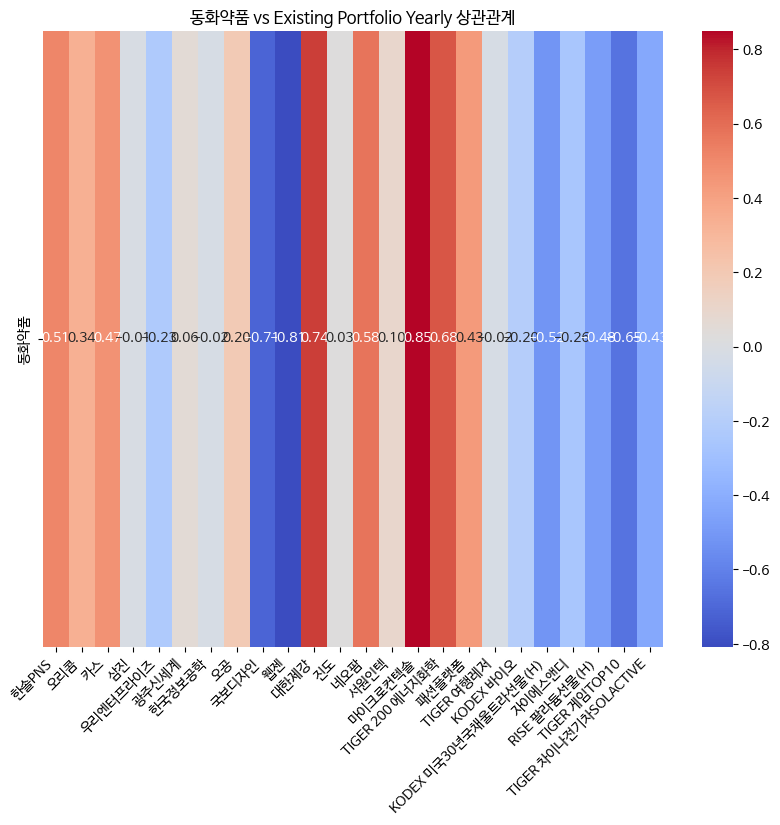

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykrx import stock
import datetime
import time

# Function to fetch market data for a given stock code and date range
def get_market_data(start_date, end_date, stock_code):
    df = stock.get_market_ohlcv(start_date, end_date, stock_code)
    return df


# Function to fetch the security name for a given stock code (determines if it's an ETF or a regular stock)
def get_security_name(stock_code):
    name = stock.get_market_ticker_name(stock_code)
    if isinstance(name, pd.DataFrame) and name.empty:  # 빈 DataFrame이면 ETF로 간주
        name = stock.get_etf_ticker_name(stock_code)
    return name

# ATR calculation function
def calculate_atr(data, period=14):
    high_low = data['고가'] - data['저가']
    high_close = np.abs(data['고가'] - data['종가'].shift())
    low_close = np.abs(data['저가'] - data['종가'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

# Existing stock codes
existing_stock_codes = [
    '010420', '010470', '016920', '032750', '037400', '037710', '039740',  '045060',
    '066620', '069080', '084010', '088790', '092730', '093920',  '098120', '139250', '225590', '228800', '244580', '304660', '317400',  
    '334690', '364990', '371460'
                        ]



# 새로운 종목 코드 (예: 새로 추가할 종목)
new_stock_code = '000020'  
# 관심 있는 주식 코드 목록에 새로운 종목 추가
all_stock_codes = existing_stock_codes + [new_stock_code]

# 각 주식에 대한 데이터를 저장할 딕셔너리
stock_data = {}

# 각 주식에 대한 시장 데이터를 가져와 딕셔너리에 저장
for code in all_stock_codes:
    
    df = get_market_data("20230102", "20240906", code)
    df.index = pd.to_datetime(df.index)
    stock_data[code] = df
    
# 새로운 종목의 시장 데이터 가져오기
df_new_stock = get_market_data("20230102", "20240906", new_stock_code)
df_new_stock.index = pd.to_datetime(df_new_stock.index)

# 새로운 종목의 ATR 계산
atr_new_stock = calculate_atr(df_new_stock)
df_new_stock['ATR'] = atr_new_stock

# Normalized ATR 계산 (ATR을 종가로 나누어 백분율로 변환)
df_new_stock['Normalized ATR (%)'] = (df_new_stock['ATR'] / df_new_stock['종가']) * 100

# 수익률과 상관관계를 계산
returns = pd.DataFrame(index=stock_data[existing_stock_codes[0]].index)
for code in all_stock_codes:
    df = stock_data[code]
    df['종가'].replace(0, np.nan, inplace=True)  # 종가가 0인 경우 NaN으로 처리
    df.dropna(subset=['종가'], inplace=True)  # NaN 값 제거
    for period, label in zip([1, 5, 20, 252], ['daily', 'weekly', 'monthly', 'yearly']):
        returns[f'{code}_{label}_return'] = df['종가'].pct_change(periods=period)

# pct_change 계산으로 인해 발생한 NaN 값을 제거
returns.dropna(inplace=True)

# 각 종목에 대한 이름을 가져오기 (ETF 여부 판단)
stock_names = {code: get_security_name(code) for code in all_stock_codes}

# 다양한 기간에 대한 상관관계 매트릭스를 계산
timeframes = ['daily', 'weekly', 'monthly', 'yearly']
correlation_matrices = {timeframe: returns.filter(regex=f'_{timeframe}_').corr() for timeframe in timeframes}

# 새로운 종목이 기존 포트폴리오와의 상관관계를 확인
new_stock_correlations = {timeframe: pd.Series(dtype=float) for timeframe in timeframes}

for timeframe, matrix in correlation_matrices.items():
    # 열 이름에서 주식 코드를 추출
    stock_codes_in_matrix = matrix.columns.str.extract(r'(\d+)')[0]
    matrix.columns = [stock_names[code] for code in stock_codes_in_matrix]  # 열 이름을 종목명으로 변경
    matrix.index = [stock_names[code] for code in stock_codes_in_matrix]  # 인덱스를 종목명으로 변경
    
    if stock_names[new_stock_code] in matrix.columns:
        # 새로운 종목과 기존 종목들 간의 상관관계
        new_stock_correlations[timeframe] = matrix[stock_names[new_stock_code]].drop(labels=[stock_names[new_stock_code]])

# Calculate the scores based on the correlation logic
correlation_scores = {}
for timeframe, correlations in new_stock_correlations.items():
    scores = []
    for corr in correlations:
        if corr > 0:
            scores.append(1-corr)  # Apply negative sign for positive correlations
        else:
            scores.append(abs(corr))  # Invert for negative correlations
    correlation_scores[timeframe] = np.mean(scores)  # Calculate average score
    
    
# Display results
print(f"새로운 종목 {stock_names[new_stock_code]}({new_stock_code})의 기존 포트폴리오와의 상관관계 점수:")
for timeframe in timeframes:
    if timeframe in correlation_scores:
        print(f"{timeframe.capitalize()} 상관관계 점수: {correlation_scores[timeframe]:.3f}")
    else:
        print(f"{timeframe.capitalize()} 상관관계 점수: 데이터 없음")
# 새로운 종목의 ATR 출력
print(f"새로운 종목 {get_security_name(new_stock_code)}({new_stock_code})의 Normalized ATR:")
print(df_new_stock[['종가', 'ATR', 'Normalized ATR (%)']])

# 선택적으로 Normalized ATR 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_new_stock.index, df_new_stock['Normalized ATR (%)'], label=f'Normalized ATR (%) ({new_stock_code})')
plt.title(f'Normalized ATR of {get_security_name(new_stock_code)} ({new_stock_code})')
plt.xlabel('Date')
plt.ylabel('Normalized ATR (%)')
plt.legend()
plt.grid(True)
plt.show()
# 선택적으로 새로운 종목의 상관관계 매트릭스를 시각화
for timeframe, correlations in new_stock_correlations.items():
    if not correlations.empty:
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlations.values.reshape(1, -1), annot=True, fmt=".2f", cmap='coolwarm', yticklabels=[stock_names[new_stock_code]], xticklabels=correlations.index)
        plt.title(f'{stock_names[new_stock_code]} vs Existing Portfolio {timeframe.capitalize()} 상관관계')
        plt.xticks(rotation=45, ha='right')
        plt.show()


새로운 종목 영보화학(014440)의 ATR:
              종가         ATR
날짜                          
2023-01-02  3285         NaN
2023-01-03  3290         NaN
2023-01-04  3355         NaN
2023-01-05  3400         NaN
2023-01-06  3430         NaN
...          ...         ...
2024-08-13  3525  105.823529
2024-08-14  3550  105.392157
2024-08-16  3590  105.470588
2024-08-19  3450  105.647059
2024-08-20  3495  105.490196

[402 rows x 2 columns]


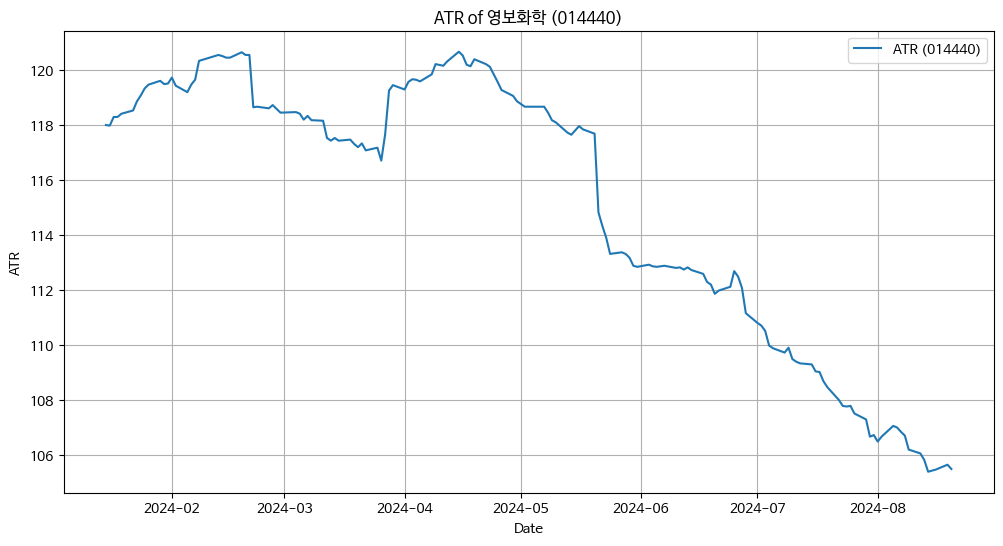

In [4]:


# ATR 계산 함수
def calculate_atr(data, period=255):
    high_low = data['고가'] - data['저가']
    high_close = np.abs(data['고가'] - data['종가'].shift())
    low_close = np.abs(data['저가'] - data['종가'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

# 새로운 종목의 ATR 계산
atr_new_stock = calculate_atr(df_new_stock)
df_new_stock['ATR'] = atr_new_stock

# 새로운 종목의 ATR 출력
print(f"새로운 종목 {get_security_name(new_stock_code)}({new_stock_code})의 ATR:")
print(df_new_stock[['종가', 'ATR']])

# 선택적으로 ATR 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_new_stock.index, df_new_stock['ATR'], label=f'ATR ({new_stock_code})')
plt.title(f'ATR of {get_security_name(new_stock_code)} ({new_stock_code})')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.grid(True)
plt.show()

새로운 종목 TIGER 소프트웨어(157490)의 기존 포트폴리오와의 평균 상관관계:
Daily 상관관계: 0.367
Weekly 상관관계: 0.346
Monthly 상관관계: 0.245
Yearly 상관관계: 0.144


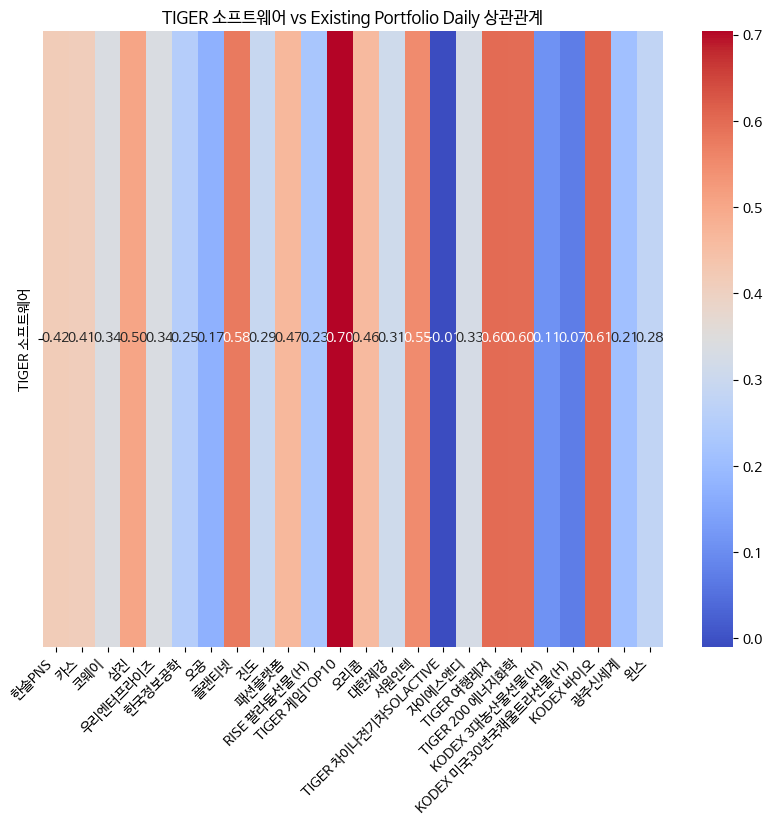

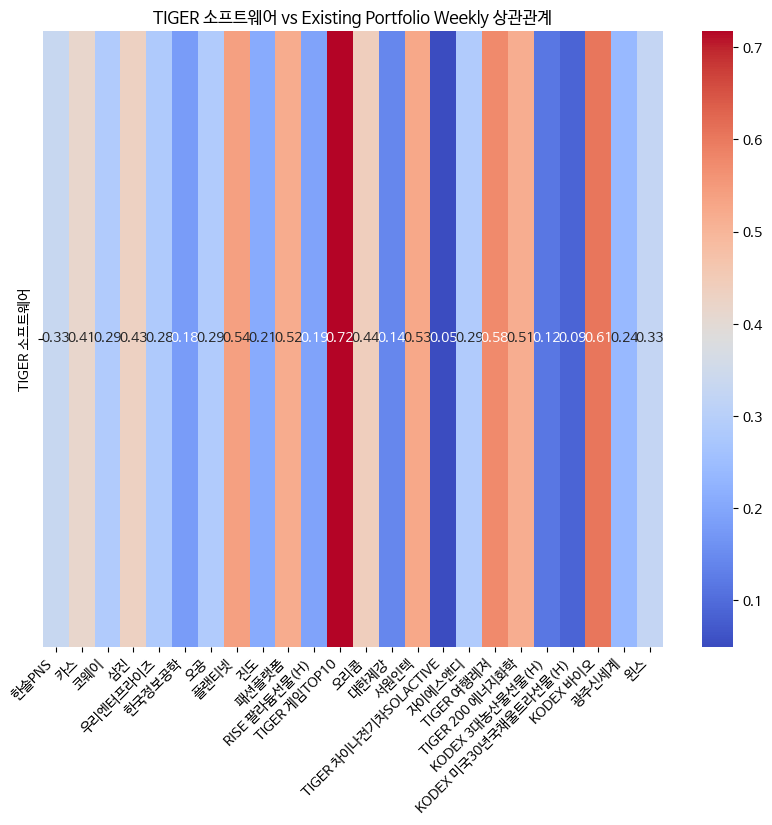

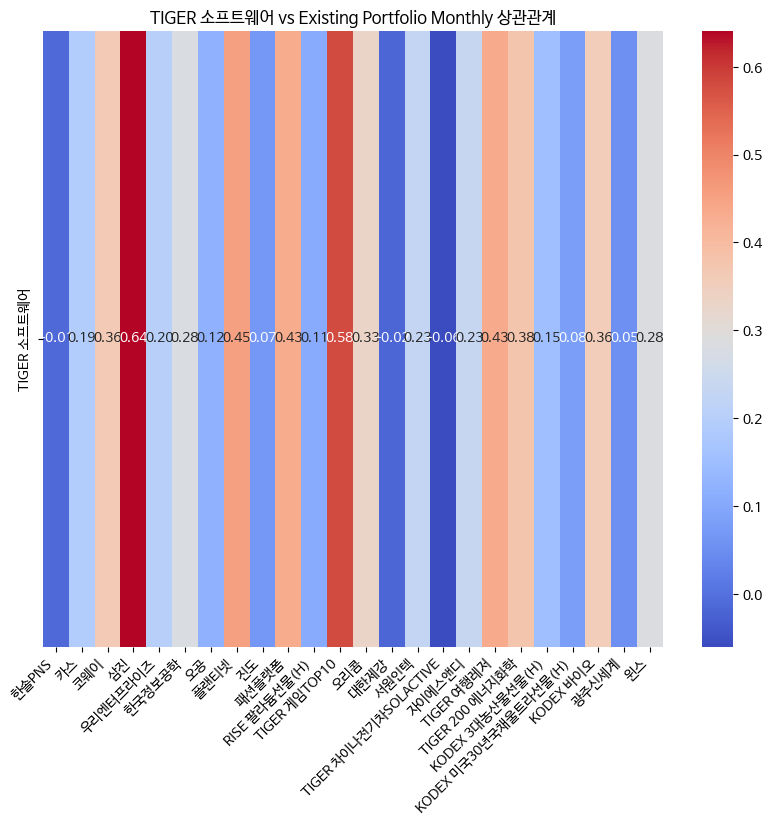

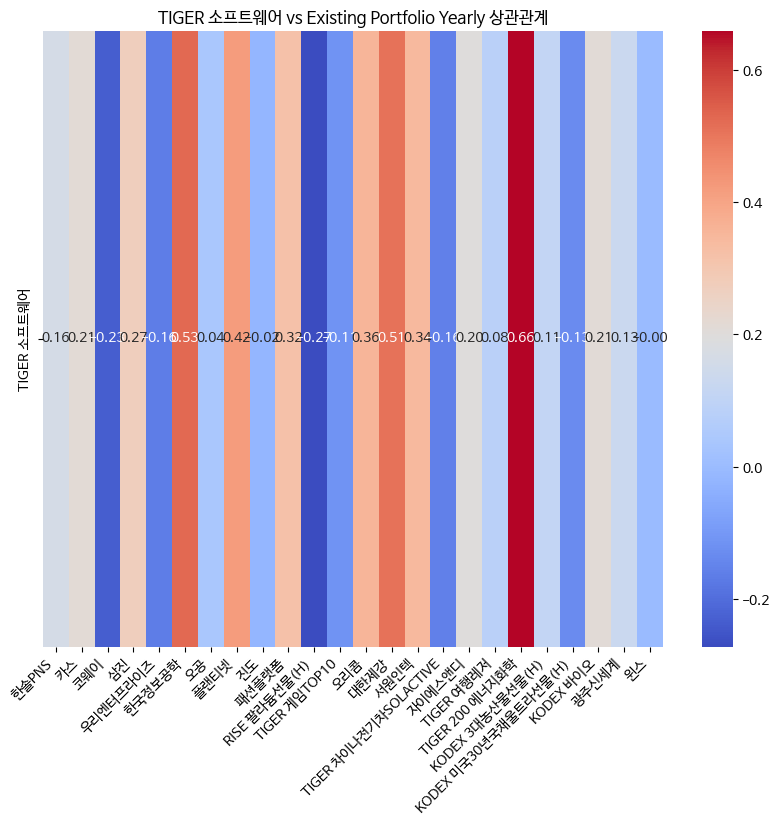

In [1]:
# backtest_strategy.py가 현재 디렉토리에 있다고 가정
import backtest_strategy

# backtest_strategy 모듈에서 필요한 함수 및 클래스 불러오기
from backtest_strategy import get_stock_codes, load_stock_data_from_mysql, select_stocks

# 예제 사용
def main():
    # DB 연결 정보 및 파라미터 설정
    db_params = {
        'user': 'your_user',
        'password': 'your_password',
        'host': 'your_host',
        'database': 'your_database'
    }

    # 샘플 날짜 및 기준 설정
    date = datetime.strptime('2024-06-01', '%Y-%m-%d')
    per_threshold = 10
    pbr_threshold = 1.5
    div_threshold = 2
    buy_threshold = 50000
    consider_delisting = True
    entered_stocks = []
    loaded_stock_data = {}

    # 종목 코드 가져오기
    stock_codes = get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, buy_threshold, db_params, consider_delisting)

    # 종목 선정 방식 선택 (normalized_atr, correlation, rank_based, random)
    stock_selection_method = 'normalized_atr'  # 원하는 방식 선택
    sorted_stock_codes = select_stocks(stock_selection_method, stock_codes, date, db_params, entered_stocks, loaded_stock_data)

    print(sorted_stock_codes)

if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'backtest_strategy'